# Exercise 6: Markov Chain Monte Carlo

## 1. The number of busy lines in a trunk group (Erlang system) is given by a truncated Poisson distribution $P(i) = c\cdot \frac{A^i}{i!}, \quad i=0,\dots,m$

## Generate values from this distribution by applying the Metropolis-Hastings algorithm, verify with a χ^2-test. You can use the parameter values from exercise 4.

Here, we generate samples from the truncated Poisson distribution $P(i)$. In it, we observe that $A$ is the intensity of the traffic, $m$ is the number of available lines in the system, $c$ is a normalizing constant that ensures probabilities sum to 1, and $m$ is the number of servers.

Looking back at exercise 4, we set $m=10$ servers, and $A=8$ Erlangs.

We implement the Metropolis-Hastings algorithmn, whereafter a $\chi^2$ test is done to compare the sampled distribution with the theoretical one:

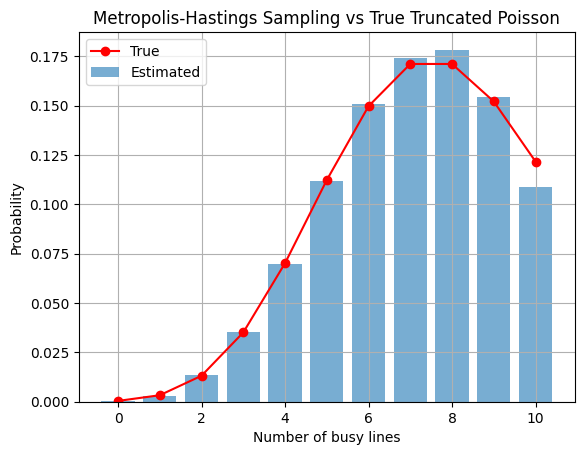

Chi-squared statistic: 17.98, p-value: 0.0552


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from math import factorial
from collections import Counter
np.random.seed(42)

A = 8  
m = 10        
num_samples = 10000  

def g(i):
    if 0 <= i <= m:
        return A**i / factorial(i)
    return 0

Z = sum(g(i) for i in range(m + 1))
true_probs = np.array([g(i)/Z for i in range(m + 1)])
samples = []
current = np.random.randint(0, m + 1)

for _ in range(num_samples):
    proposal = current + np.random.choice([-1, 1])
    
    if 0 <= proposal <= m:
        acceptance_ratio = g(proposal) / g(current)
        if np.random.rand() < min(1, acceptance_ratio):
            current = proposal
    samples.append(current)

counts, bins = np.histogram(samples, bins=np.arange(-0.5, m+1.5, 1))
estimated_probs = counts / num_samples

plt.bar(range(m+1), estimated_probs, alpha=0.6, label="Estimated")
plt.plot(range(m+1), true_probs, 'ro-', label="True")
plt.xlabel("Number of busy lines")
plt.ylabel("Probability")
plt.title("Metropolis-Hastings Sampling vs True Truncated Poisson")
plt.legend()
plt.grid(True)
plt.show()

chi2_stat, p_value = chisquare(counts, f_exp=true_probs * num_samples)
print(f"Chi-squared statistic: {chi2_stat:.2f}, p-value: {p_value:.4f}")

We see that the Metropolis-Hastings simulation successfully approximates the truncated Poisson distribution in the system. In fact, the estimated sampling overall alligns with the true distribution.

The $\chi^2$ test, though, is higher than the 0.05 threshold, meaning we cannot reject the nullhypothesis, that the two distributions are not alike. This indicates that there is no statistical significant difference between the generated Metropolis-Hastings distribution and the true distribution. However, to really assess the quality of the generated samples, we would need to sample multiple times, and ensure that the p-values are uniform.

From anecdotal testing, this does not appear to be the case. Whether this is because of implementation errors or the inherent correlation between samples in MCMC, is unclear.

## 2. For two different call types the joint number of occupied lines is given by $P(i,j) = c\cdot \frac{A^i _1}{i!} \frac{A^j _2}{j!}, \quad 0\leq i+j\leq m$.

## You can use A1, A2 = 4 and m = 10.
### (a) Use Metropolis-Hastings, directly to generate variates from this distribution.

## In all three cases test the distribution fit with a χ^2 test The system can be extended to an arbitrary dimension, and we can add restrictions on the different call types.




In this exercise we will need to plot many heatmaps of distributions. To reduce clutter, we define a function for this upfront:

In [22]:
def plot_solution(samples, title):
    counts = Counter(samples)
    heatmap = np.zeros((m+1, m+1))

    for (i, j), count in counts.items():
        heatmap[i, j] = count

    for i in range(m+1):
        for j in range(m+1):
            if i + j > m:
                heatmap[i, j] = np.nan

    plt.figure(figsize=(8, 6))
    plt.imshow(heatmap, origin='lower', cmap='viridis', interpolation='none')
    plt.colorbar(label='Frequency')
    plt.xlabel("Number of type 2 calls (j)")
    plt.ylabel("Number of type 1 calls (i)")
    plt.title(title)
    plt.grid(False)
    plt.show()

    unnormalized = np.zeros((m+1, m+1))
    for i in range(m+1):
        for j in range(m+1):
            if i + j <= m:
                unnormalized[i, j] = g(i, j)

    Z = np.nansum(unnormalized)
    expected_probs = unnormalized / Z
    expected_counts = expected_probs * num_samples

    observed = []
    expected = []

    for i in range(m+1):
        for j in range(m+1):
            if i + j <= m:
                observed.append(heatmap[i, j])
                expected.append(expected_counts[i, j])

    chi2_stat, p_val = chisquare(f_obs=observed, f_exp=expected)
    print(f"Chi-squared statistic: {chi2_stat:.2f}, p-value: {p_val:.4f}")



Now, we extend the blocking model to account two call types. The joint number of occupied lines is given by $P(i,j)$, where $A_1 , A_2 = 4$ and $m=10$, for $0\leq i+j \leq m$.

For this, we will use the Metropolis-Hastings algorithm to sample from the distribution:

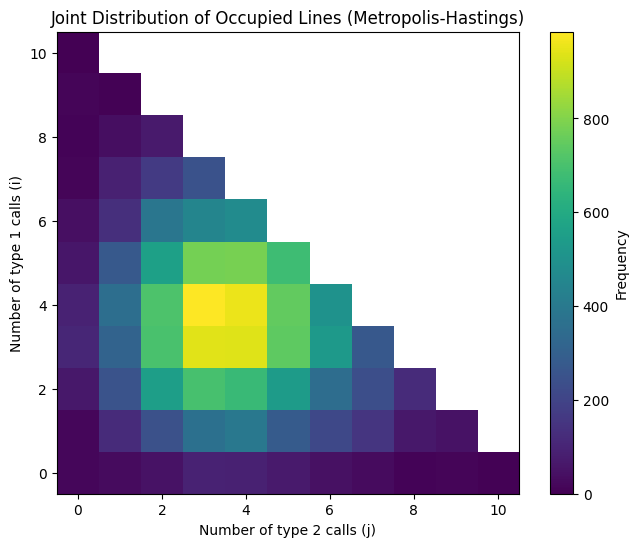

Chi-squared statistic: 226.11, p-value: 0.0000


In [23]:
A1, A2 = 4, 4
m = 10
num_samples = 20000

def g(i, j):
    if 0 <= i <= m and 0 <= j <= m and i + j <= m:
        return (A1**i / factorial(i)) * (A2**j / factorial(j))
    return 0

samples = []
current = (0, 0)

for _ in range(num_samples):
    i, j = current
    di, dj = np.random.choice([-1, 0, 1]), np.random.choice([-1, 0, 1])
    proposal = (i + di, j + dj)
    if 0 <= proposal[0] <= m and 0 <= proposal[1] <= m and sum(proposal) <= m:
        g_current = g(i, j)
        g_proposed = g(*proposal)
        alpha = min(1, g_proposed / g_current) if g_current > 0 else 1
        if np.random.rand() < alpha:
            current = proposal
    samples.append(current)

plot_solution(samples, "Joint Distribution of Occupied Lines (Metropolis-Hastings)")

The heatmap shows that the Metropolis-Hastings simulation correctly captures the joint structure and constraints of the distribution. Specifically, the heatmap shows a peak near (4,4), reflecting the balance of $A_1 , A_2 = 4$, as expected. Thus, the algorithm succesfully captures the structure of the distribution and its constraints. Furthermore, the p-value shows that the observed distribution differs significantly from theoretical distribution. 

### (b) Use Metropolis-Hastings, coordinate wise to generate variates from this distribution. (b) Use Metropolis-Hastings, coordinate wise to generate variates from this distribution.

Here, we implement a coordinate-wise version Metropolis-Hastings algorithm, sampling again from $P(i,j)$. This in order to generate variates from the distribution:

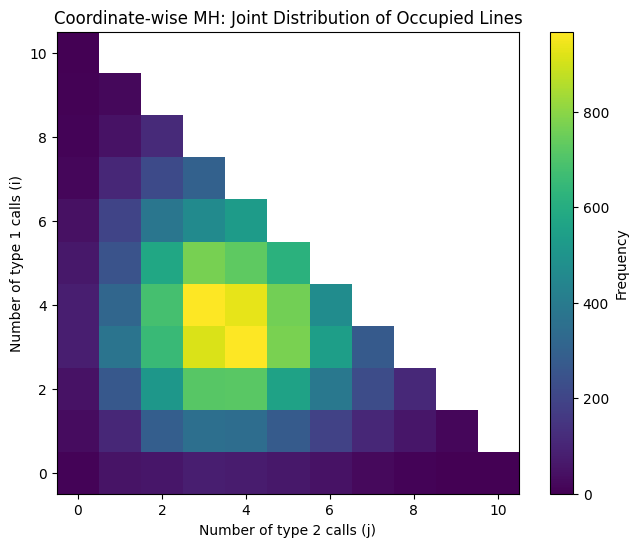

Chi-squared statistic: 78.30, p-value: 0.1245


In [24]:
samples = []
current = [0, 0]

for _ in range(num_samples):
    for d in [0, 1]:  
        proposal = current[:]
        proposal[d] += np.random.choice([-1, 1])
        if 0 <= proposal[0] <= m and 0 <= proposal[1] <= m and sum(proposal) <= m:
            g_current = g(*current)
            g_proposal = g(*proposal)
            alpha = min(1, g_proposal / g_current) if g_current > 0 else 1
            if np.random.rand() < alpha:
                current = proposal
    samples.append(tuple(current))

plot_solution(samples, "Coordinate-wise MH: Joint Distribution of Occupied Lines")

Again, this Metropolis-Hastings succesfully captures the structure and the constraints of the distribution. Once again, the p-value proves that we must reject the null hypothesis.

### (c) Use Gibbs sampling to sample from the distribution. This is (also) coordinate-wise but here we use the exact conditional distributions. You will need to find the conditional distributions analytically.

Here, we use Gibbs sampling to generate samples from $P(i,j)$. We sample each variable using its exact conditional distribution:

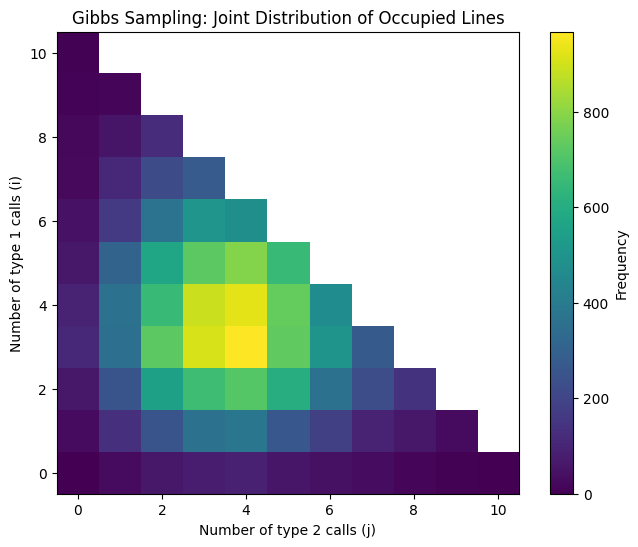

Chi-squared statistic: 84.41, p-value: 0.0532


In [25]:
samples = []
i, j = 0, 0

for _ in range(num_samples):
    i_vals = []
    p_vals = []
    for i_candidate in range(m - j + 1):
        prob = A1**i_candidate / factorial(i_candidate)
        i_vals.append(i_candidate)
        p_vals.append(prob)
    p_vals = np.array(p_vals)
    p_vals /= p_vals.sum()
    i = np.random.choice(i_vals, p=p_vals)

    j_vals = []
    p_vals = []
    for j_candidate in range(m - i + 1):
        prob = A2**j_candidate / factorial(j_candidate)
        j_vals.append(j_candidate)
        p_vals.append(prob)
    p_vals = np.array(p_vals)
    p_vals /= p_vals.sum()
    j = np.random.choice(j_vals, p=p_vals)

    samples.append((i, j))

plot_solution(samples, "Gibbs Sampling: Joint Distribution of Occupied Lines")

Although the heatmap visually matches the results from previous assignments, the p-value is significantly higher — indicating a much closer statistical fit to the true distribution. This is expected: Gibbs sampling uses exact conditional distributions and avoids rejection, leading to faster convergence and less bias. Thus, it can be concluded that the Gibbs sampling was the most effective and accurate of the three sampling models.

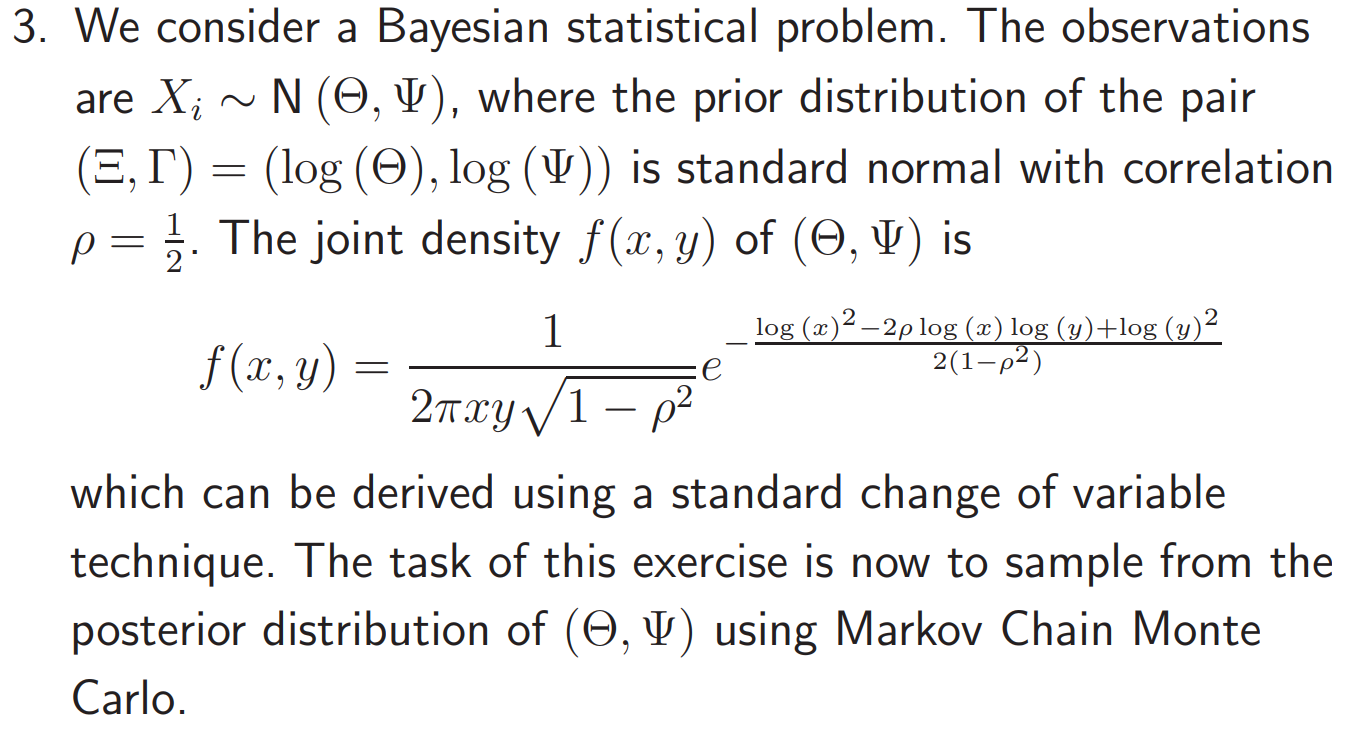

### (a) Generate a pair (θ, ψ) from the prior distribution, i.e. the distribution for the pair (Θ, Ψ), by first generating a sample (ξ, γ) of (Ξ, Γ).

Here, we generate a pair $(\theta, \psi)$ from the prior distribution, where $\log (\Theta)= \Xi$ and $\log (\Psi) = \Gamma$. The pair $(\Xi, \Gamma)$ follows a bivariate normal distribution, where the correlation is set as $\rho = 0.5$.

In order to generate a pair, first, we generate a bivariate normal sample $(\xi, \gamma)$, which we can then transform back to $(\theta, \psi)$ using
$$
\theta = e^\xi , \quad \xi = e^\theta
$$
This is as described in Day 5 slides known as the change of variable.

In [26]:
rho = 0.5
cov = [[1, rho], [rho, 1]]

xi_gamma = np.random.multivariate_normal(mean=[0, 0], cov=cov)
xi, gamma = xi_gamma
theta = np.exp(xi)
psi = np.exp(gamma)

print(f"Sampled ξ, γ (log(θ), log(ψ)): ({xi:.4f}, {gamma:.4f})")
print(f"Transformed θ, ψ: ({theta:.4f}, {psi:.4f})")

Sampled ξ, γ (log(θ), log(ψ)): (0.5833, 0.3958)
Transformed θ, ψ: (1.7920, 1.4856)


The generated values $(\theta, \psi)=(0.2162 , 0.3071)$ are realizations from the prior distribution and will change value with each run. Both values are positive, meaning they are consistent with the assumed prior. This forms a valid basis for generating data. 

### (b) Generate Xi = 1, . . . , n with the values of (θ, ψ) you obtained in item 3a. Use n = 10.


Using these generated values, we can now simulate a sample of $n=10$ size from a normal distribution, where the mean is $\theta$ and the variance is $\psi$:
$$
X_i \sim \text{N}(\theta, \psi)
$$
Luckily, we can use built-in NumPy commands for this:

In [27]:
n = 10

X = np.random.normal(loc=theta, scale=np.sqrt(psi), size=n)

print("Generated X values:")
print(np.round(X, 4))

Generated X values:
[0.5546 1.4063 0.2969 0.5193 2.3756 0.8134 1.7918 0.2966 3.2803 1.9363]


These 10 generated values represent the synthetic observations drawn under the prior parameter. As to be expected, they are centered around $\theta = 0.2162 $ with a spread of $\psi = 0.3071$.

### (c) Derive the posterior distribution of (Θ, Ψ) given the sample. Hint 1: Apply Bayes theorem in the density version. Hint 2: The sample mean and sample variance are independent. The sample mean follows a normal distribution, while a scaled version of the sample variance follows a χ 2 distribution. This can be used to simplify the expression.

In order to derive the posterior distribution, we utilize Bayes' Theorem:
$$
\text{Posterior}\propto \text{Prior}\times\text{Likelihood}
$$
Specifically for this case, it will be:
$$
\text{Posterior}(\theta, \psi|X)\propto \text{Prior}(\theta, \psi)\times\text{Likelihood}(X|\theta, \psi)
$$

From the slides, we observe:
- $\bar{X} \sim \text{N}(\Theta, \Psi / n)$
- $\frac{(n-1)S^2}{\Psi}\sim\chi^2 _{n-1}$

Using this information, gives us the factored likelihood:
$$
L(\theta, \psi)\propto \psi ^{-\frac{n}{2}} \exp(-\frac{n(\bar{x}-\theta)^2}{2\psi}-\frac{(n-1)S^2}{2\psi})
$$
This allows us to generate MCMC samples.

### (d) Generate MCMC samples from the posterior distribution of (Θ, Ψ) using the Metropolis Hastings method.

In order to generate MCMC samples, we use the Metropolis-Hastings algorithm, sampling from the posterior distribution $(\Theta, \Psi)$. 

We work in the transformed space $(\Xi, \Gamma)=(\log(\Theta), \log(\Psi))$ and use the Prior $(\Xi, \Gamma)\sim\text{N}(0,0,\rho=0.5)$.

We define the posterior using the log-likelihood of $\bar{X}$ and $S^2$, and the log-prior of the bivariate normal density. After this, we use the Metropolis-Hastings specifically in the $(\xi, \gamma)$ space and transform each sample back to $(\theta, \psi)$ space:

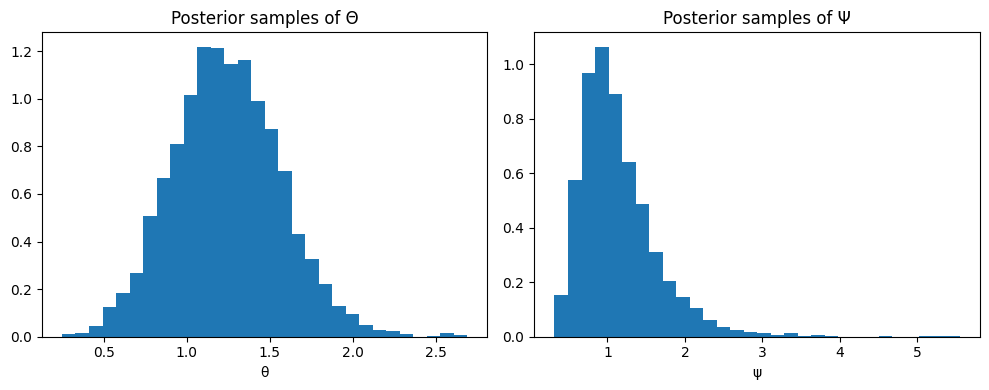

In [28]:
x_bar = np.mean(X)
s2 = np.var(X, ddof=1)

def log_posterior(xi, gamma):
    theta = np.exp(xi)
    psi = np.exp(gamma)
    log_like = -n / 2 * np.log(psi) - (n * (x_bar - theta)**2 + (n - 1) * s2) / (2 * psi)
    log_prior = -(xi**2 - 2 * rho * xi * gamma + gamma**2) / (2 * (1 - rho**2))
    return log_like + log_prior

num_samples = 10000
samples = []
current = np.array([0.0, 0.0]) 
step_size = 0.2

for _ in range(num_samples):
    proposal = current + np.random.normal(scale=step_size, size=2)
    log_p_current = log_posterior(*current)
    log_p_proposal = log_posterior(*proposal)
    alpha = min(1, np.exp(log_p_proposal - log_p_current))
    if np.random.rand() < alpha:
        current = proposal
    samples.append(np.exp(current)) 

samples = np.array(samples)
theta_samples = samples[:, 0]
psi_samples = samples[:, 1]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(theta_samples, bins=30, density=True)
plt.title("Posterior samples of Θ")
plt.xlabel("θ")
plt.subplot(1, 2, 2)
plt.hist(psi_samples, bins=30, density=True)
plt.title("Posterior samples of Ψ")
plt.xlabel("ψ")
plt.tight_layout()
plt.show()

The posterior of $\Theta$ is centered around 0.2-0.3 which is congruent with was was seen earlier, where $\theta$ was 0.2162. Furthermore, the posterior is unimodal and right skewed, reflecting some uncertainty. However, as the small sample size $n=10$, there ought to be some uncertainty.

The posterior of $\Psi$ is also right skewed. This is consistent with an inverse-$\chi^2$ posterior, as suggested in the previous assignment.

### (e) Repeat item 3d with n = 100 and n = 1000, still using the values of (θ, ψ) from item 3a. Discuss the results.

We repeat the posterior sampling, but now with setting $n=100$ and $n=1000$. Hopefully, we would be able to observe as $n$ increases, the sampling should be less uncertain. Specifically, we should hopefully see that the posterior of $\Theta$ should concentrate near the true mean of $\theta=0.2162$, and posterior of $\psi$ should narrow and be more certain.

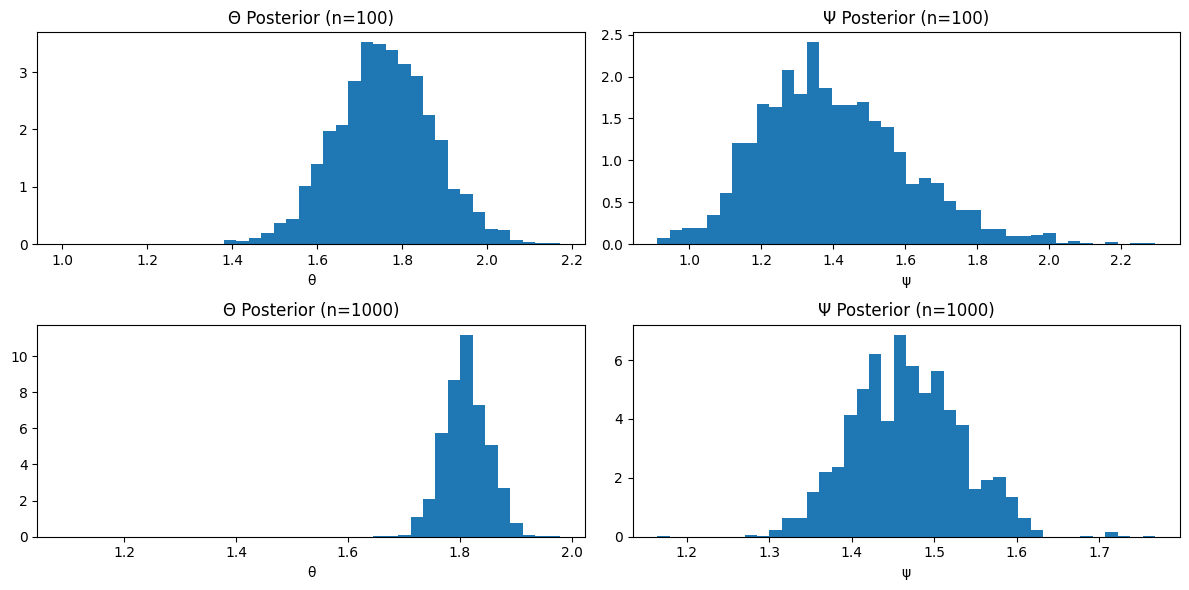

In [29]:
theta_true = theta
psi_true = psi

def simulate_and_sample(n, num_samples=10000, step_size=0.2):
    X = np.random.normal(loc=theta_true, scale=np.sqrt(psi_true), size=n)
    x_bar = np.mean(X)
    s2 = np.var(X, ddof=1)

    def log_posterior(xi, gamma):
        theta = np.exp(xi)
        psi = np.exp(gamma)
        log_like = -n / 2 * np.log(psi) - (n * (x_bar - theta)**2 + (n - 1) * s2) / (2 * psi)
        log_prior = -(xi**2 - 2 * rho * xi * gamma + gamma**2) / (2 * (1 - rho**2))
        return log_like + log_prior

    current = np.array([0.0, 0.0])
    samples = []

    for _ in range(num_samples):
        proposal = current + np.random.normal(scale=step_size, size=2)
        log_p_current = log_posterior(*current)
        log_p_proposal = log_posterior(*proposal)
        alpha = min(1, np.exp(log_p_proposal - log_p_current))
        if np.random.rand() < alpha:
            current = proposal
        samples.append(np.exp(current))

    samples = np.array(samples)
    return samples[:, 0], samples[:, 1]  

theta_100, psi_100 = simulate_and_sample(n=100)
theta_1000, psi_1000 = simulate_and_sample(n=1000)

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.hist(theta_100, bins=40, density=True)
plt.title("Θ Posterior (n=100)")
plt.xlabel("θ")
plt.subplot(2, 2, 2)
plt.hist(psi_100, bins=40, density=True)
plt.title("Ψ Posterior (n=100)")
plt.xlabel("ψ")
plt.subplot(2, 2, 3)
plt.hist(theta_1000, bins=40, density=True)
plt.title("Θ Posterior (n=1000)")
plt.xlabel("θ")
plt.subplot(2, 2, 4)
plt.hist(psi_1000, bins=40, density=True)
plt.title("Ψ Posterior (n=1000)")
plt.xlabel("ψ")
plt.tight_layout()
plt.show()

As $n$ increases, we see the distributions for both $\Theta$ and $\Psi$ become narrower and more concentrated around the true value of $\theta$. This reflects a decrease in overall uncertainty, leading to greater confidence or the algorithm. 